<a href="https://colab.research.google.com/github/MoltenMuffins/IndoorAudioClassifier/blob/master/AudioAsImage_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



VGG model trained on self created database of sounds from freesound

Classes: Speech, Music, Water, Door Sounds, Car horn, Glass Breaking

## 0. Boilerplate Code

In [0]:
#test for gpu
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
#imports here
import os
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

import tensorflow as tf

tf.VERSION

'1.12.0'

## 1. Download Dataset

We use a small labeled dataset generated via the freesound api and passed through an audio tokeniser to shorten exceedingly long sound files.

It has the following file structure: `Dataset/Train/{CLASS_LABEL}/{FILENAME}.jpg`

In [0]:
#Download Dataset from dropbox
!wget -qq https://www.dropbox.com/s/rv7xzjyvae0nabt/Data.zip

In [0]:
#Unzip and delete zip file
!unzip -qq Data.zip
!rm Data.zip
!ls

## 2. Prepare Dataset for Model

We use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.

We also then split them up so we have 10% for a testing set and the rest for training.

Finally we randomly shuffle them up

In [0]:
path = "./Data/"
train_data_dir = "./Data/Train/"

In [0]:
import pandas as pd
import glob

filenames_n0 = glob.glob('./Data/Train/car horn/*.png')
filenames_n1 = glob.glob('./Data/Train/door/*.png')
filenames_n2 = glob.glob('./Data/Train/glass break/*.png')
filenames_n3 = glob.glob('./Data/Train/music/*.png')
filenames_n4 = glob.glob('./Data/Train/speech/*.png')
filenames_n5 = glob.glob('./Data/Train/water/*.png')


names = ['car horn', 'door', 'glass break', 'music', 'speech', 'water']

len(filenames_n0)

52

In [0]:
# Make a dataframe based on the filenames
df = pd.DataFrame(filenames_n0, columns = ["filename"])
df2 = pd.DataFrame(filenames_n1, columns = ["filename"])
df3 = pd.DataFrame(filenames_n2, columns = ["filename"])
df4 = pd.DataFrame(filenames_n3, columns = ["filename"])
df5 = pd.DataFrame(filenames_n4, columns = ["filename"])
df6 = pd.DataFrame(filenames_n5, columns = ["filename"])


# Add Class columns 
df['class'] = pd.Series([0 for x in range(len(df.index))], index=df.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)
df3['class'] = pd.Series([2 for x in range(len(df3.index))], index=df3.index)
df4['class'] = pd.Series([3 for x in range(len(df4.index))], index=df4.index)
df5['class'] = pd.Series([4 for x in range(len(df5.index))], index=df5.index)
df6['class'] = pd.Series([5 for x in range(len(df6.index))], index=df6.index)


# Split into train and validation sets
train_set_percentage = .9

#1
train_df = df[:int(len(df)*train_set_percentage)]
val_df = df[int(len(df)*train_set_percentage):]

#2
train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]

#3
train_df3 = df3[:int(len(df3)*train_set_percentage)]
val_df3 = df3[int(len(df3)*train_set_percentage):]

#4
train_df4 = df4[:int(len(df4)*train_set_percentage)]
val_df4 = df4[int(len(df4)*train_set_percentage):]

#5
train_df5 = df5[:int(len(df5)*train_set_percentage)]
val_df5 = df5[int(len(df5)*train_set_percentage):]

#6
train_df6 = df6[:int(len(df6)*train_set_percentage)]
val_df6 = df6[int(len(df6)*train_set_percentage):]

df_new_train = pd.concat([train_df, train_df2, train_df3, train_df4, train_df5, train_df6])
df_new_val = pd.concat([val_df, val_df2, val_df3, val_df4, val_df5, val_df6])

In [0]:
# shuffle dataframes
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

print('number of train files:', len(df))
print('number of val files:', len(df_val))
df.head(10)

number of train files: 905
number of val files: 104


,filename,class
0,./Data/Train/water/washing-machine_clip17.png,5
1,./Data/Train/water/Water_Spitting.png,5
2,./Data/Train/door/Door_bedroom_medium.png,1
3,"./Data/Train/speech/""Otros piensan por mí"".png",4
4,./Data/Train/speech/corpspeech_clip6.png,4
5,./Data/Train/car horn/Field-Recording.BCN.Stre...,0
6,./Data/Train/music/Modern Music Loop 130 bpm_c...,3
7,./Data/Train/door/stairwell door-panic bar and...,1
8,./Data/Train/door/Door .png,1
9,./Data/Train/water/drinking water_clip0.png,5


In [0]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 6

df.shape

(905, 2)

In [0]:
train_filenames_list[:5]

['./Data/Train/water/washing-machine_clip17.png',
 './Data/Train/water/Water_Spitting.png',
 './Data/Train/door/Door_bedroom_medium.png',
 './Data/Train/speech/"Otros piensan por mí".png',
 './Data/Train/speech/corpspeech_clip6.png']

## 3. Code To Run Tensorboard

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!rm ngrok-stable-linux-amd64.zip
!ls

--2019-01-09 01:29:25--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.204.22.7, 34.231.75.48, 34.206.130.40, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.204.22.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  3.46MB/s    in 1.5s    

2019-01-09 01:29:27 (3.46 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ngrok                   
Data  __MACOSX	ngrok  sample_data


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=32,
                         write_images=True)

## 4. VGG16

### 4.1 Create Data Pipeline for VGG16

In [0]:
#As our image is greyscale (single channel) we need to do something to it to make it 3 channeled

# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.

def _parse_function(filename, label):
  image_string = tf.read_file(filename)
  #Channels specified to be 3 to ensure images output as [224,224,3] at the end of this
  image_decoded = tf.image.decode_jpeg(image_string, channels=3)
  label = tf.one_hot(label, num_classes)
  return image_decoded, label

In [0]:
# Create vector of filenames from list
filenames = tf.constant(train_filenames_list)

# Create vector of labels
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

### 4.2 Asemble Data Pipeline using tf.data for VGG16

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(32)

valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(32)

In [0]:
# create the base pre-trained model
base_model = VGG16(weights=None, include_top=False, input_shape=(64, 32, 3))
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 8, 128)        0         
__________

In [0]:
# add a global spatial average pooling layer
x = base_model.output

x = Flatten()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

# and a logits layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

In [0]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
#Unecessary
for layer in base_model.layers:
    layer.trainable = True

In [0]:
#optional
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 8, 128)        0         
__________

In [0]:
opt = tf.train.AdamOptimizer(learning_rate = 0.00001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

### 4.3 Transfer Learning on VGG16

In [0]:
#60 20 20 rule
train_steps = 60
val_steps = 20
epochs = 30

In [0]:
#sanity check
print(train_dataset)
print(valid_dataset)

<BatchDataset shapes: ((?, ?, ?, 3), (?, 6)), types: (tf.uint8, tf.float32)>
<BatchDataset shapes: ((?, ?, ?, 3), (?, 6)), types: (tf.uint8, tf.float32)>


In [0]:
#Generates a URL you can click once model starts training. You can monitor progress from the URL.
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://1f188e60.ngrok.io


In [0]:
# # # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps, callbacks=[tbCallBack])

## 5. Model Adhoc Test

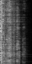

In [0]:
image_path = './Data/Test/'

from IPython.display import Image

#Filenames:'horn.png', 'door.png', 'glass.png', 'music.png', 'speech.png', 'water.png'
image_check = 'water.png'
#These files are not present in the train set

Image(image_path+image_check)

In [0]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import numpy as np

img_path = os.path.join(image_path, image_check)
print(img_path)
img = image.load_img(img_path, target_size=(64,32))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

./Data/Test/water.png
Input image shape: (1, 64, 32, 3)


In [0]:
preds = model.predict(x)
print(preds)

[[6.5728859e-06 4.3611025e-04 1.5465342e-04 9.6649331e-01 3.2658439e-02
  2.5098614e-04]]


In [0]:
import operator
def decode(preds):
  names = ['car horn', 'door', 'glass break', 'music', 'speech', 'water']
  probs = preds[0].tolist()
  dictionary = dict(zip(names, probs))  
  return sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)
  
decode(preds)

[('music', 0.9664933085441589),
 ('speech', 0.03265843912959099),
 ('door', 0.0004361102473922074),
 ('water', 0.00025098613696172833),
 ('glass break', 0.00015465341857634485),
 ('car horn', 6.5728859226510394e-06)]

From the difference between the train accuracy and validation accuracy we can tell that the model is overfitting. There is also a much heavier weight on the music class as despite testing a variety of sound files, music is always the predicted class. The audioasimage approach seems to not work well, alternatively there might simply be not enough data in the dataset, or the dataset is not cleaned enough